In [119]:
import os
import sys
import numpy as np
from skimage import measure
from scipy import ndimage
from tqdm import tqdm
import torch
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from monai.transforms import (
    AsDiscrete,
    Compose,
    EnsureType,
    ToTensor,
    AddChannel
)
import yaml
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from monai.metrics import DiceMetric
sys.path.append('/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/')
from dataloader import train_dataloader, val_dataloader
from models import unet512
sys.path.append("/home/local/VANDERBILT/litz/github/MASILab/thoraxtools")
import func.vis.vis as vis

In [2]:
def load_config(config_name, config_dir):
    with open(os.path.join(config_dir, config_name)) as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
    return config
config_id = "0418cv_luna16"
CONFIG_DIR = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/configs"
config = load_config(f"Config_{config_id}.YAML", CONFIG_DIR)

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device("cuda:0")
model = unet512().to(device)
test_metric = DiceMetric(include_background=False, reduction="mean")

images = glob.glob(os.path.join(config["data_dir"], config["image_type"]))
test_loader = val_dataloader(config, images)

model_path = os.path.join(config["model_dir"], config_id, f"fold1", f"{config_id}_best_model.pth")
print(model_path)
model.load_state_dict(torch.load(model_path))
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=6)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=6)])

Validation sample size: 47
/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0418cv_luna16/fold1/0418cv_luna16_best_model.pth


In [15]:
n_tests = 20

In [70]:
model.eval()
test_metric.reset()
inputs = []
labels = []
outputs = []
with torch.no_grad():
    # iter_test_loader = iter(test_loader)
    # for i in tqdm(range(n_tests)):
    for test_data in tqdm(test_loader):
        # test_data = next(iter_test_loader)
        test_inputs, test_labels = (test_data["image"].to(device),
                                    test_data["label"].to(device))
        
        # run inference and save output
        test_outputs = sliding_window_inference(test_inputs, config["crop_shape"], 4, model)
        np_output = torch.argmax(test_outputs, dim=1)[0,:,:,:].detach().cpu().numpy()
        
        # compute dice
        test_outputs = [post_pred(i) for i in decollate_batch(test_outputs)]
        test_labels = [post_label(i) for i in decollate_batch(test_labels)]
        test_metric(y_pred=test_outputs, y=test_labels)
        
        # save input and labels
        if test_metric.get_buffer()[-1, 3] < 0.8:
            np_input = test_data["image"][0, 0, :, :, :].detach().cpu().numpy()
            np_label = test_data["label"][0, 0, :, :, :].detach().cpu().numpy()

            inputs.append(np_input)
            labels.append(np_label)
            outputs.append(np_output)
    
    # compute dice over all images
    dice_scores = test_metric.get_buffer()
    mean_dice = test_metric.aggregate().item()
    test_metric.reset()
    print(mean_dice)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [06:58<00:00,  8.90s/it]

0.9306537508964539


In [73]:
print(torch.mean(dice_scores, dim=1))
x, y, z = 150, 150, 160
print(len(labels))
# for i in range(len(labels)):
#     # vis.showslice(inputs[i], x,y,z, is_gray=True)
#     vis.showslice(labels[i], x,y,z)
#     vis.showslice(outputs[i], x,y,z)

tensor([0.9574, 0.9592, 0.9687, 0.9172, 0.8889, 0.9653, 0.9435, 0.9552, 0.9630,
        0.9244, 0.9769, 0.9515, 0.9606, 0.9682, 0.9622, 0.9526, 0.9726, 0.9271,
        0.8646, 0.9628, 0.9507, 0.6866, 0.8352, 0.9103, 0.8818, 0.9171, 0.9649,
        0.8848, 0.9452, 0.9436, 0.9367, 0.9671, 0.9563, 0.9552, 0.9496, 0.9309,
        0.8692, 0.9721, 0.9396, 0.9516, 0.9422, 0.9605, 0.7224, 0.9709, 0.9334,
        0.9629, 0.9581], device='cuda:0')
10


### Connected components

In [74]:
def getLargestCC(binaryImg, connectivity=1):
    """
    :param binaryImg: binary 3d float array
    :param connectivity: https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label
    """
    labels = measure.label(binaryImg, connectivity=connectivity)
    largestCC = labels==np.argmax(np.bincount(labels.flat, weights=binaryImg.flat))
    return largestCC

val_transforms = Compose([
    AddChannel(),
    EnsureType(),
    AsDiscrete(to_onehot=6)
])

cc_metric = DiceMetric(include_background=False, reduction="mean")
val_metric =  DiceMetric(include_background=False, reduction="mean")

mergedCCs = []
for j, img in enumerate(outputs):
    mergedCC = np.zeros(img.shape)
    for i in range(5):
        label = i+1
        mbinary = np.where(img==label, 1, 0)
        cc = getLargestCC(mbinary, connectivity=1)
        mergedCC += cc*label
    mergedCCs.append(mergedCC)

    merged = [val_transforms(mergedCC)]
    output = [val_transforms(img)]
    label = [val_transforms(labels[j])]

    cc_metric(y_pred=merged, y=label)
    val_metric(y_pred=output, y=label)

cc_scores = cc_metric.get_buffer()
val_scores = val_metric.get_buffer()
mean_dice_cc = cc_metric.aggregate().item()
mean_dice_val = val_metric.aggregate().item()
cc_metric.reset()
val_metric.reset()
print(mean_dice_cc)
print(mean_dice_val)
print(torch.mean(cc_scores, dim=1))
print(torch.mean(dice_scores, dim=1))

0.8710006475448608
0.846813976764679
tensor([0.9165, 0.9575, 0.9058, 0.6935, 0.9113, 0.9140, 0.9234, 0.8957, 0.8695,
        0.7229])
tensor([0.9574, 0.9592, 0.9687, 0.9172, 0.8889, 0.9653, 0.9435, 0.9552, 0.9630,
        0.9244, 0.9769, 0.9515, 0.9606, 0.9682, 0.9622, 0.9526, 0.9726, 0.9271,
        0.8646, 0.9628, 0.9507, 0.6866, 0.8352, 0.9103, 0.8818, 0.9171, 0.9649,
        0.8848, 0.9452, 0.9436, 0.9367, 0.9671, 0.9563, 0.9552, 0.9496, 0.9309,
        0.8692, 0.9721, 0.9396, 0.9516, 0.9422, 0.9605, 0.7224, 0.9709, 0.9334,
        0.9629, 0.9581], device='cuda:0')


In [94]:
print(mean_dice_cc)
print(mean_dice_val)
print(torch.mean(cc_scores, dim=1))
print(torch.mean(val_scores, dim=1))

0.8710006475448608
0.846813976764679
tensor([0.9165, 0.9575, 0.9058, 0.6935, 0.9113, 0.9140, 0.9234, 0.8957, 0.8695,
        0.7229])
tensor([0.8889, 0.9244, 0.8646, 0.6866, 0.8352, 0.9103, 0.8818, 0.8848, 0.8692,
        0.7224])


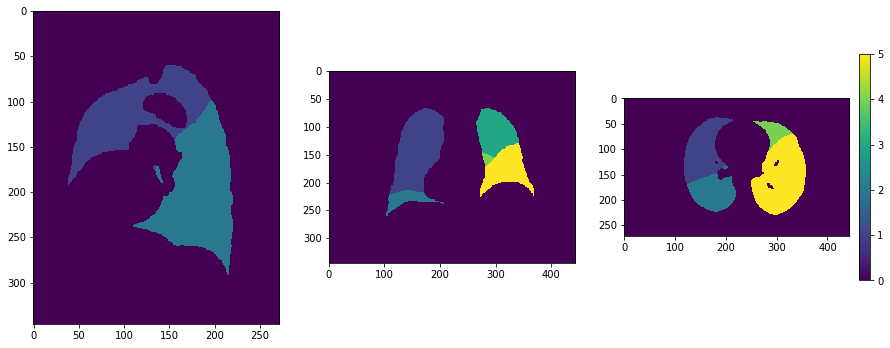

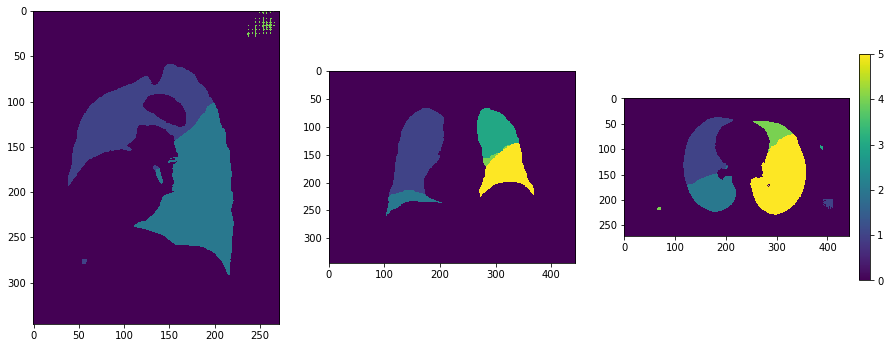

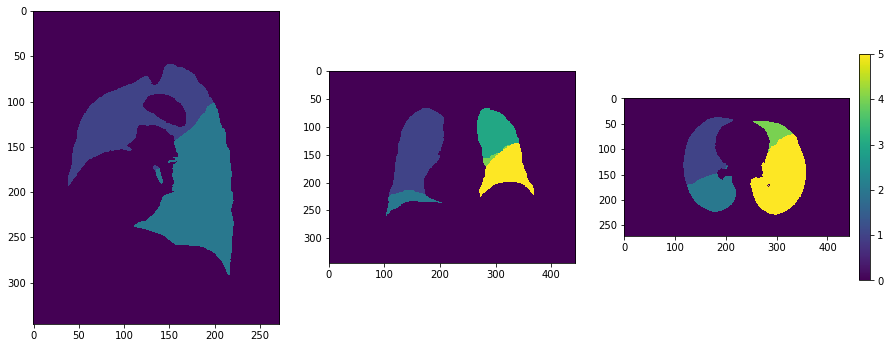

In [88]:
x,y,z = (200, 160, 170)
i = 4
# vis.showslice(inputs[i],x,y,z, is_gray=True)
vis.showslice(labels[i],x,y,z)
vis.showslice(outputs[i], x,y,z)
vis.showslice(mergedCCs[i], x,y,z)

<AxesSubplot:>

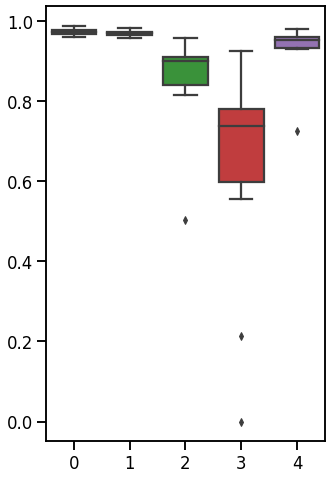

In [109]:
# sns.set_context(context="talk")
f, ax = plt.subplots(figsize=(5,8))
sns.boxplot(data=cc_scores)

# ax.yaxis.grid(True)

<AxesSubplot:>

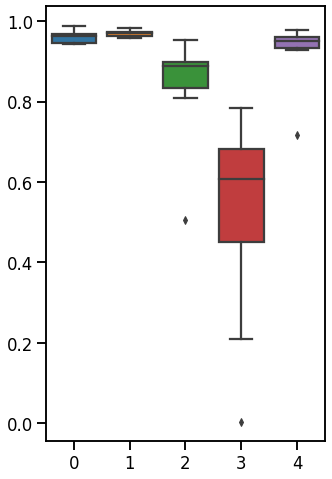

In [110]:
f, ax = plt.subplots(figsize=(5,8))
sns.boxplot(data=val_scores)


connected components clearly improve the median and standard deviation of dice scores for RML segmentation by 0.15 points (from 0.6 to 0.75)

### Nearest label filling
Motivation: Since finding CCs is a reductionary operation, previously labeled voxels may loose labels. The nearest lable filling algorithm label voxels in the lung field that were labeled before cc reduction. implementation:
1. find signed distance transform of each lobe, where more negative is inside the segmentation and more positive is outside
2. subtract the binary pre-cc image from the binary post-cc image to find voxels that lost labels
3. for each such voxel, assign it the label that corresponds to the smallest dt value across all lobes
4. find cc - this will remove voxels in the background that were labeled

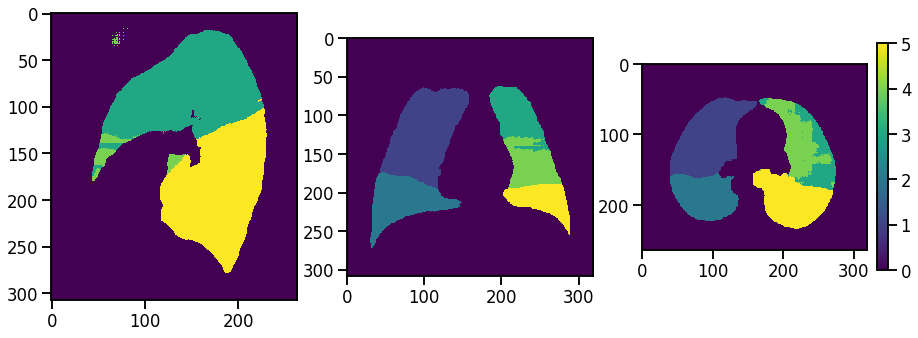

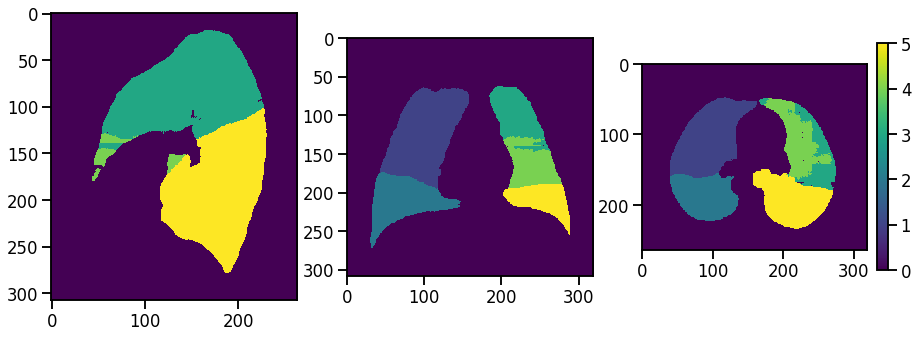

In [114]:
x,y,z = (200, 160, 170)
i = 0
# vis.showslice(inputs[i],x,y,z, is_gray=True)
# vis.showslice(labels[i],x,y,z)
vis.showslice(outputs[i], x,y,z)
vis.showslice(mergedCCs[i], x,y,z)

In [172]:
output = outputs[0]
mergedcc = mergedCCs[0]

dst_no_labels = np.zeros((5, *output.shape))
no_label = np.where(output, 1, 0) - np.where(mergedcc, 1, 0)
for i in range(5):
# i=3
    label = i+1
    binary = np.where(mergedcc==label, 1, 0)
    inv_binary = np.where(mergedcc==label, 0, 1)

    output_dst = -ndimage.distance_transform_cdt(binary) + ndimage.distance_transform_cdt(inv_binary)
    # cc_binary = np.where(mergedcc==label, 1, 0)
    dst_no_labels[i, :, :, :] = np.where(no_label, output_dst, 0)



In [178]:
nearest = np.argmin(dst_no_labels, axis=0)
nearest = np.where(no_label, nearest+1, 0)
mergedcc_nearest = mergedcc + nearest


In [179]:
dst_no_labels.shape

(5, 319, 264, 308)

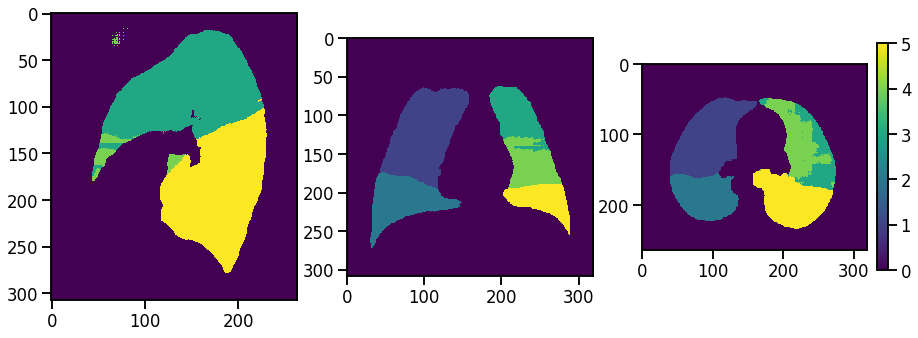

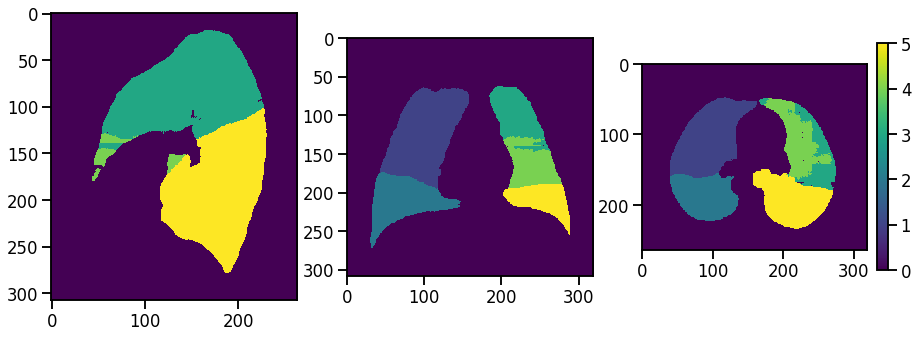

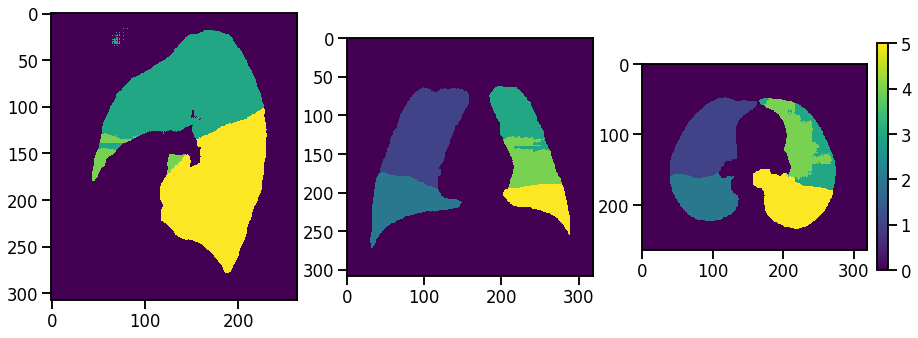

In [182]:
x, y, z = (200, 160, 170)
# vis.showslice(no_label, x,y,z)
# vis.showslice(nearest, x, y, z)
vis.showslice(output, x, y, z)
vis.showslice(mergedcc, x, y, z)
vis.showslice(mergedcc_nearest, x, y, z)

# vis.showslice(output_dst, x, y, z, clip_range=[-15, 20])


In [183]:
nearest_cc = np.zeros(mergedcc_nearest.shape)
for i in range(5):
    label = i+1
    mbinary = np.where(mergedcc_nearest==label, 1, 0)
    cc = getLargestCC(mbinary, connectivity=1)
    nearest_cc += cc*label

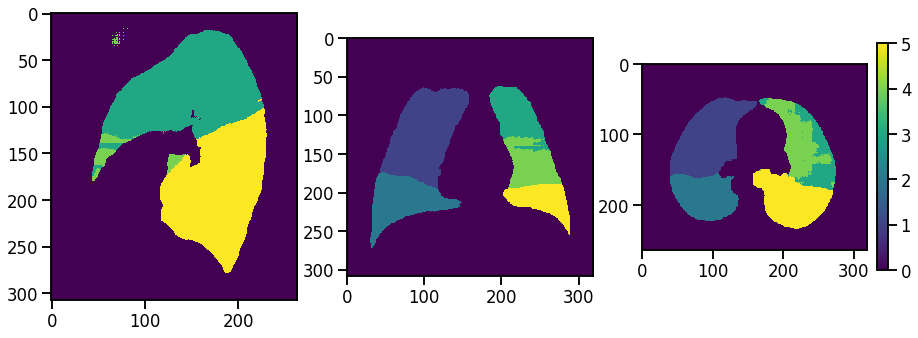

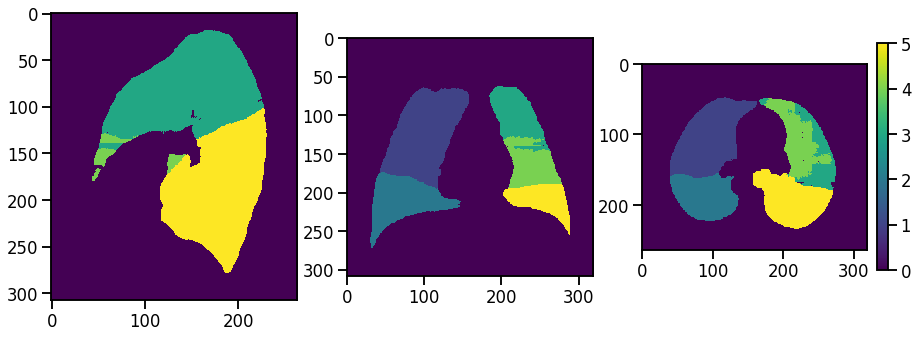

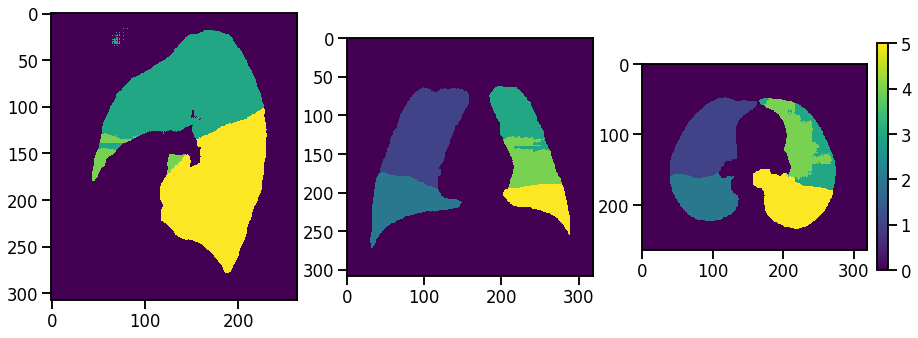

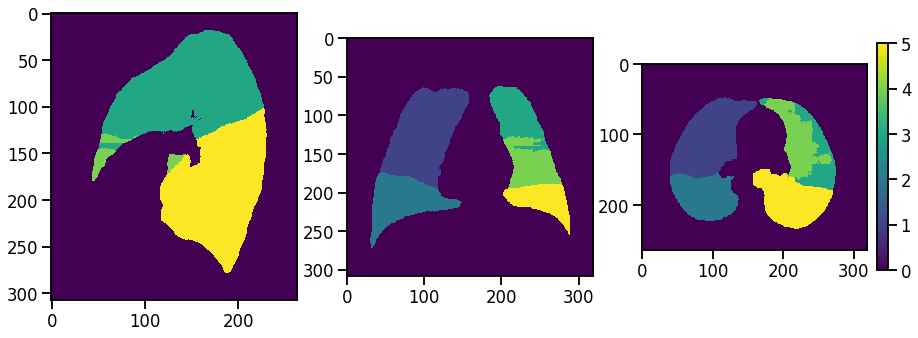

In [184]:
vis.showslice(output, x, y, z)
vis.showslice(mergedcc, x, y, z)
vis.showslice(mergedcc_nearest, x, y, z)
vis.showslice(nearest_cc, x, y, z)